## Segmentação de Clientes
<b> Descrição: </b>
<p> Uma empresa vende alguns produtos e precisa saber como está o seu desempenho de vendas. Como a base de dados tem um tamhno considerável é impossivel que 
tal análise seja feita "a olho nú". Então, podemos segmentar clientes com base em seu comportamento de compra usando algorítimos de Machine learnig (K-Means, etc...) e o incrível poder da computação. </p>

<p>Para tal tarefa teremos que: </p>

-  Compreender o conjunto de dados e efetuar sua limpeza (caso necessário);
- Construir um modelo de clustering para segmentar os clientes com base na sua similaridade;
- Ajuste dos hiperparâmetros e comparação de alguns algorítimos de classificação.
*** 

#### Criemos então um plano de ação para organizar melhor nossos passos até a solução do problema: 
<ol>
<li> Exploração da base de dados; </li>
<li> Análise exploratória dos dados; </li>
<li> Pre-processamento dos dados; </li>
<li> Manipulação dos dados; </li>
<li> Modelagem preditiva; </li>
<li> Resultados e conclusão. </li>
</ol>

***

##### Importação de bibliotecas

In [1]:
import pandas as pd

import os
import math
import scipy
import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [35,10]

import warnings
warnings.filterwarnings('ignore')



### 1. Carga e exploração dos dados

In [28]:
#Carga dos dados
df = pd.read_excel('Data\Online Retail.xlsx')

In [3]:
#Criação de cópia do Dataframe
dfOriginal = df.copy(deep=True)

#Mostrando em tela as 5 primeiras linhas
display(df.head())

# Análise superficial do DataSet
print(' \n\033[1mConsiderações:\033[0m  A base de dados consiste em: {} Colunas  & {} Amostras. Sendo que temos {} tipos de produtos diferentes.'.format(df.shape[1], df.shape[0], len(df.Description.unique())))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


 
Considerações:  A base de dados consiste em: 8 Colunas  & 541909 Amostras. Sendo que temos 4224 tipos de produtos diferentes.


In [74]:
# Criando Tabela MRF
df_s = df.sample(10000, random_state=42)
#Transformando 'InvoiceDate' em tipo date
df_s['InvoiceDate'] = df_s['InvoiceDate'].dt.date
#Calculando Valor total de venda
df_s['ValorTotal'] = df_s['Quantity'] * df_s['UnitPrice']

df_s.rename(columns={'CustomerID' : 'IDCliente'}, inplace=True)

date_m = max(df_s['InvoiceDate'] + datetime.timedelta(days=1))

#Agrupando Clientes por ID e agregando contagem de 'data da fatura', contagem de 'Número da Fatura' e 'Valor total' 
clientes = df_s.groupby(by='IDCliente').agg({'InvoiceDate' : lambda x: (date_m - x.max()).days, 
'InvoiceNo' :'count', 'ValorTotal':'sum'})

#Renomeando as colunas
clientes.rename(columns = {'InvoiceDate': 'Recência','InvoiceNo': 'Frequencia'}, inplace=True)

display(clientes.head())




,Recência,Frequencia,ValorTotal
IDCliente,,,
12347.0,3,5,81.60
12349.0,19,1,19.90
12353.0,205,1,39.80
12354.0,233,2,25.45
12356.0,326,1,50.00


In [75]:
""" Limpando valores negativos de Clientes
clientes = clientes[clientes.TotalValue>0]
print(clientes.TotalValue.min())
"""
print(clientes.ValorTotal.min())

-1867.86


In [76]:
# Checagem dos tipos de todas as colunas
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2433 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recência    2433 non-null   int64  
 1   Frequencia  2433 non-null   int64  
 2   ValorTotal  2433 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 76.0 KB


In [77]:
clientes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Recência,2433.0,115.114673,105.746852,1.00,30.0,73.00,191.0,374.00
Frequencia,2433.0,3.076038,5.693838,1.00,1.0,2.00,3.0,137.00
ValorTotal,2433.0,60.757185,205.094177,-1867.86,12.4,24.77,53.1,4887.33


***
- Em análise sumária, as estatísticas parecem boas. Vamos entender melhor os dados por meio de análise gráfica.
***

### 2. Análise exploratória dos dados.

RMF Distribuição de Variáveis


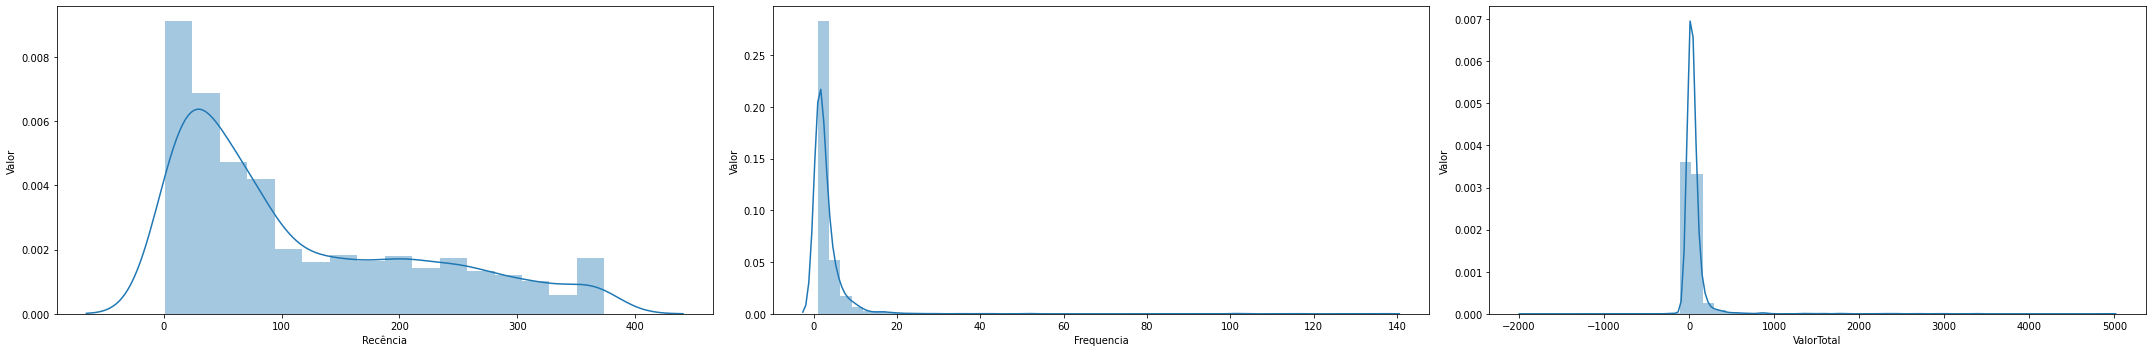

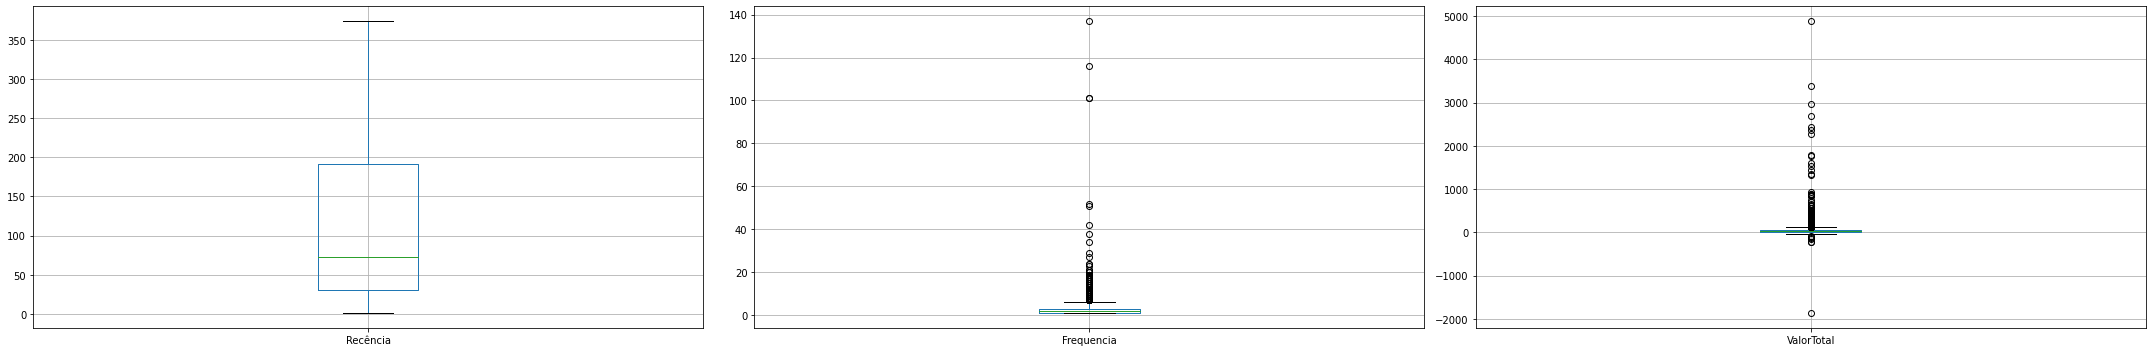

In [92]:
print('\033[1mRMF Distribuição de Variáveis')

ngraficos = 3
col = [i for i in clientes.columns]

#Ajustando o tamanho do plot gráfico
plt.figure(figsize=[30, 5*math.ceil(len(col)/ngraficos)])

#Plotando informações
for c in range(len(col)):
    plt.subplot(math.ceil(len(col)/ngraficos),ngraficos, c+1)
    plt.ylabel('Valor')
    sns.distplot(clientes[col[c]])

plt.tight_layout()
plt.show()    

plt.figure(figsize=[30,5*math.ceil(len(col)/ngraficos)])
for c in range(len(col)):
    plt.subplot(math.ceil(len(col)/ngraficos),ngraficos,c+1)
    clientes.boxplot(col[c])
plt.tight_layout()
plt.show()